test

In [ ]:
from pathlib import Path

def list_files_in_directory(directory):
    path = Path(directory)
    for file_path in path.rglob('*'):
        if file_path.is_file():
            print(file_path)

# 示例
directory_path = 'dataset'  # 替换为您的文件夹路径
list_files_in_directory(directory_path)


In [6]:
from pathlib import Path

# 给定路径
file_path = Path('dataset/Bodleian Library/2229bb6b-5fad-4e2b-81ce-ccc204773598.jpg')

# 提取目录名和文件名（不包括扩展名）
dir_name = file_path.parent.name  # 提取 'Bodleian Library'
file_name = file_path.stem  # 提取 '2229bb6b-5fad-4e2b-81ce-ccc204773598'

# 组合结果
result = f"{dir_name}/{file_name}"
print(result)

Bodleian Library/2229bb6b-5fad-4e2b-81ce-ccc204773598


In [1]:

# from sam2.build_sam import build_sam2
# from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
# import torch
# from sam2.sam2_image_predictor import SAM2ImagePredictor
# from PIL import Image


# #open photo
# image = Image.open('../dataset/Beinecke Library/3431755.jpg')
# image = np.array(image.convert("RGB"))



# #load checkpoint
# sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
# model_cfg = "sam2_hiera_l.yaml"

# sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# mask_generator = SAM2AutomaticMaskGenerator(sam2)

# masks = mask_generator.generate(image)

# print(len(masks))
# print(masks[0].keys())

# plt.figure(figsize=(20, 20))
# plt.imshow(image)
# show_anns(masks)
# plt.axis('off')
# plt.show() 


import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import cv2
import json


#show segment result

def show_anns(anns, borders=True, save_path=None):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

def filtered_anns_to_file(anns, filepath):
    filtered_anns = [
        {
            'predicted_iou': ann['predicted_iou'],
            'stability_score': ann['stability_score']
        }
        for ann in anns
    ]
    with open(filepath, 'wb') as pickle_file:
        pickle.dump(filtered_anns, pickle_file)

def filtered_anns_to_json(anns, filepath):
    filtered_anns = [
        {
            'predicted_iou': ann['predicted_iou'],
            'stability_score': ann['stability_score']
        }
        for ann in anns
    ]
    with open(filepath, 'wb') as f:
        json.dump(filtered_anns, f)

def apply_mask_and_crop(img, mask, crop_size=(100, 100), save_path=None):
    """
    读取图像，应用掩码，裁剪为指定大小的图像。

    参数:
    - image_path: 图像的路径
    - mask: 掩码数组，大小应与图像的宽高相同，布尔数组或0/1数组
    - crop_size: 要裁剪的输出图像大小 (宽, 高)
    
    返回:
    - 裁剪并应用掩码的图像
    """
    # 创建一个黑色的空白图像
    masked_img = np.zeros_like(img)

    # 应用掩码，将掩码区域的图像像素保留下来
    masked_img[mask == 1] = img[mask == 1]

    # 找到掩码区域的最小外接矩形坐标
    x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))

    # 裁剪图像，根据掩码区域裁剪
    cropped_img = masked_img[y:y+h, x:x+w]

    if save_path is not None:
        cv2.imwrite(save_path, cropped_img)
        print(f"Image saved to {save_path}")
    
    return cropped_img

    # # 调整裁剪后的图像到指定大小
    # cropped_resized_img = cv2.resize(cropped_img, crop_size)

    # # 返回裁剪并调整大小后的图像
    # return cropped_resized_img




def generate_input_point(img):
    # 询问用户希望输入多少个点
    num_points = int(input("请输入您想要选择的点的数量："))

    plt.imshow(img, cmap='gray')
    pts = plt.ginput(n=num_points)  # 用户选择指定数量的点
    print(f"Selected points: {pts}")
    plt.show()
    return pts, [1]*len(pts)



def pointMaskGenerator(sam2, image):

    mask_generator = SAM2AutomaticMaskGenerator(sam2)
    input_point, input_label = generate_input_point(image)
    masks = mask_generator.generate(image)

    print(len(masks))
    print(masks[0].keys())

    save_path = './segres/'+os.path.splitext(os.path.basename(image_path))[0]+'/'
    #no exist then create
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    filtered_anns_to_file(masks, save_path+'anns.pickle')
    # filtered_anns_to_json(masks, save_path+'anns.json')
    for i,mask in enumerate(masks):
        apply_mask_and_crop(image, mask['segmentation'], save_path=save_path+f'{i}.png')
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    show_anns(masks, save_path=save_path+'final.png')
    plt.axis('off')
    # plt.show() 



using device: cuda:1


/scratch/students/jiaxunliu/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


KeyboardInterrupt: 

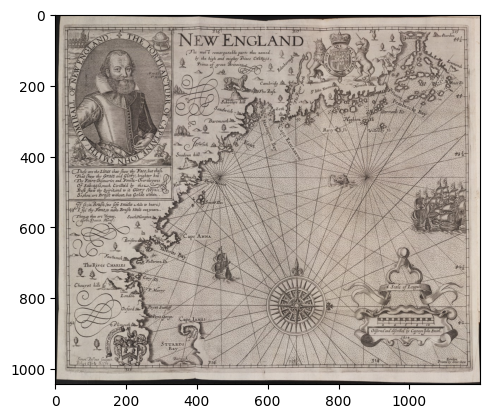

In [2]:
#Environment Set-up

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda:1")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda").__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

np.random.seed(3)


#show example
image_path = 'images/3431780.jpg'
image = Image.open(image_path)
image = np.array(image.convert("RGB"))

#automatic generation
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
pointMaskGenerator(sam2, image)

In [1]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

print(topics)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0, -1, 57, 4, 76, 197, 44, 0, 0, -1, 112, -1, -1, 87, 103, 17, 4, 109, 65, 102, -1, -1, -1, 5, 0, 88, -1, 129, -1, -1, 6, 40, 21, 0, 30, 10, -1, 96, 5, -1, 89, 20, 51, -1, 0, -1, -1, 12, 1, -1, 92, 6, 40, 1, 70, 113, -1, -1, 8, 161, 0, -1, 9, -1, -1, 150, 0, -1, -1, -1, 22, 24, 42, 79, -1, -1, 0, 34, 16, 0, 52, 6, -1, 51, 29, -1, -1, 24, 136, 177, 0, 2, 107, 159, 17, 22, 41, -1, -1, -1, 176, -1, -1, 3, 2, 0, -1, -1, -1, 128, 10, -1, 68, 13, 17, 57, -1, 150, 0, -1, -1, 77, -1, -1, -1, -1, -1, 2, -1, -1, 208, 117, 85, 0, 4, 2, 41, 1, 4, 23, -1, 10, 86, 60, -1, 1, 10, 9, 0, 104, 5, 5, 4, -1, 95, -1, -1, 3, -1, 18, -1, 2, -1, -1, -1, -1, 139, 89, -1, 30, 19, -1, 28, -1, -1, -1, 0, -1, 5, 0, 73, 0, 75, -1, -1, 2, -1, 195, 17, -1, -1, -1, 2, -1, 183, 48, 56, -1, -1, -1, -1, -1, 3, -1, -1, 6, 16, -1, 50, 14, 5, 64, -1, 7, 5, 109, -1, -1, 58, 2, 0, 32, 4, 6, 1, -1, 1, 5, -1, 0, -1, -1, -1, 55, 0, -1, -1, 0, 0, 60, 151, 151, 30, -1, -1, 12, 2, -1, 170, 25, 149, 163, 55, -1, -1, 26, 38, -1, 4, 

In [10]:
docs

["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any other high-per

In [3]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6721,-1_to_and_of_the,"[to, and, of, the, is, for, in, you, it, that]",[\nA question for you - can you give me the na...
1,0,1821,0_game_team_games_he,"[game, team, games, he, players, season, hocke...","[The problem with your nihilistic approach, Ro..."
2,1,617,1_key_clipper_chip_encryption,"[key, clipper, chip, encryption, keys, escrow,...",[-----BEGIN PGP SIGNED MESSAGE-----\n\nPlease ...
3,2,465,2_ites_yep_huh_ken,"[ites, yep, huh, ken, why, each, of, , , ]","[each, \nwhy?, \nYep.\n]"
4,3,464,3_israel_israeli_jews_arab,"[israel, israeli, jews, arab, jewish, arabs, p...",[\n\n[After a small refresh Hasan got on the t...
...,...,...,...,...,...
214,213,10,213_ftp_coppy_files_uncompress,"[ftp, coppy, files, uncompress, nicfunetfi, po...",[How can I find these files and graphics that ...
215,214,10,214_media_publications_spiking_news,"[media, publications, spiking, news, digging, ...","[\n\n\nIs this the same Monolithic, Centrally ..."
216,215,10,215_zoroastrians_osiris_masonry_nimrod,"[zoroastrians, osiris, masonry, nimrod, leopar...","[[I'm going to cut ""Rex""'s ramblings down a bi..."
217,216,10,216_ear_wax_ears_syringe,"[ear, wax, ears, syringe, widex, vida, aids, h...",[I have a fairly severe high frequency hearing...


Try to import text result

In [2]:
import pickle

with open('./result/textres/text_embedding.pickle', 'rb') as f:
    text_emb = pickle.load(f)
# text_emb

In [3]:

from bertopic import BERTopic

docs = text_emb

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs) #could send embedding into

print(topics)


[14, 6, 3, -1, 3, 1, 4, 4, 1, -1, 1, 1, 21, 4, 7, 6, 6, 8, 2, 0, 1, 19, 2, 3, 5, 20, -1, 11, 2, -1, 15, 17, 0, 0, 6, 2, -1, 12, 2, 9, 0, 4, -1, 4, -1, 0, 2, 1, 1, 13, 12, 2, 0, 2, 20, 3, -1, 4, -1, 16, 2, 4, 15, 12, 12, 9, 0, 1, 1, 3, -1, 6, 5, -1, 8, -1, 3, 6, 13, 12, -1, 20, 1, 4, 4, 22, 4, 6, 12, 3, -1, 3, -1, 2, 3, 9, 0, -1, -1, 5, -1, 13, 0, 9, 3, 5, 18, 3, 17, -1, 11, -1, 4, -1, 2, -1, 17, 12, 2, 18, 2, 0, 14, 12, 0, -1, 15, 15, 15, 15, -1, 2, 15, 14, 2, 14, 14, 2, 2, 7, 11, 19, -1, 3, 4, 3, 0, 8, 0, 6, 5, 1, 0, 8, 21, 10, 13, -1, 6, 3, -1, 1, 4, 8, 0, 1, 1, 10, 19, 19, 21, 7, 3, 8, 21, 3, 11, 4, 5, 9, -1, 2, 7, 1, -1, 10, 11, 7, 19, 4, 4, 4, 0, 8, 18, 0, 16, 1, 16, 0, 8, 1, -1, 2, 4, 0, 9, 9, 7, 2, 1, 16, 22, 10, 7, 1, 14, 0, 10, 10, 5, 8, 0, 14, 10, 19, 19, 0, 7, 0, 4, 10, 16, 10, 4, 8, 3, 10, 2, 3, 10, 7, 7, 7, 22, 16, 16, 4, 11, 14, 4, 11, 16, 0, 16, 2, 7, 16, 4, 17, 20, 4, 3, 0, 1, 11, -1, 18, 0, 2, -1, 0, -1, 3, 3, 9, -1, 0, 2, -1, 17, 5, -1, 11, 3, 12, 2, 3, 0, 2, 2, 3, 3,

In [4]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,81,-1_on_clock_tower_white,"[on, clock, tower, white, it, statue, with, wo...",[a castle with a tower and a clock on top [SEP...
1,0,72,0_blurry_shows_looks_like,"[blurry, shows, looks, like, distorted, very, ...","[very blurry and it looks like a tree [SEP], v..."
2,1,68,1_long_tail_horse_head,"[long, tail, horse, head, cat, fish, elephant,...",[a fish with a long tail and a long tail [SEP]...
3,2,66,2_map_of_the_drawn,"[map, of, the, drawn, country, island, area, w...","[drawn on the map of the island [SEP], drawn o..."
4,3,59,3_background_black_blue_white,"[background, black, blue, white, with, and, se...","[blue and white with a black background [SEP],..."
5,4,50,4_similar_to_very_interesting,"[similar, to, very, interesting, the, detailed...","[very similar to the design of the ship [SEP],..."
6,5,29,5_brown_blue_white_and,"[brown, blue, white, and, sep, gray, yellow, ,...","[blue and brown [SEP], blue and brown [SEP], b..."
7,6,27,6_color_blue_in_white,"[color, blue, in, white, amount, and, quote, l...","[white and blue in color [SEP], blue and white..."
8,7,27,7_leaf_tree_green_with,"[leaf, tree, green, with, it, small, on, cente...","[a tree with a green leaf on it [SEP], a tree ..."
9,8,27,8_stem_long_leaf_trunk,"[stem, long, leaf, trunk, tail, with, very, tr...","[a leaf with a long stem [SEP], a leaf with a ..."


In [6]:
(text_emb)

NameError: name 't_emb' is not defined

In [15]:


from bertopic import BERTopic

docs = text_emb

topic_model = BERTopic()
t_emb = t_emb.cpu().numpy()
topics, probs = topic_model.fit_transform(docs, embeddings=t_emb) #could send embedding into

print(topics)


[15, 10, 3, -1, 3, 1, 4, 4, 1, -1, 1, 1, 20, 4, 13, 10, 10, 8, 2, 0, 1, 22, 2, 3, 6, 21, -1, 7, 2, -1, 16, 17, 0, 0, 10, 2, 5, 11, 2, 5, 0, 4, -1, 4, -1, 0, 2, 1, 1, 9, 11, 2, 0, 2, 21, 3, -1, 4, -1, 14, 2, 4, 16, 11, 11, 5, 0, 1, 1, 3, 18, 10, 6, -1, 8, 18, 3, 10, 9, 11, -1, 21, 1, 4, 4, 23, 4, 10, 11, 3, -1, 3, -1, 2, 3, 5, 0, 5, -1, 6, 18, 9, 0, 5, 3, 6, 19, 3, 17, -1, 7, -1, 4, -1, 2, -1, 17, 11, 2, 19, 2, 0, 15, 11, 0, -1, 16, 16, 16, 16, -1, 2, 16, 15, 2, 15, 15, 2, 2, 13, 7, 22, 5, 3, 4, 3, 0, 8, 0, 10, 6, 1, 0, 8, 20, 12, 9, 5, 10, 3, 5, 1, 4, 8, 0, 1, 1, 12, 22, 22, 20, 13, 3, 8, 20, 3, 7, 4, 6, 5, -1, 2, 13, 1, 5, 12, 7, 13, 22, 4, 4, 4, 0, 8, 19, 0, 14, 1, 14, 0, 8, 1, -1, 2, 4, 0, 5, 5, 13, 2, 1, 14, 23, 12, 13, 1, 15, 0, 12, 12, 6, 8, 0, 15, 12, 22, 22, 0, -1, 0, 4, 12, 14, 12, 4, 8, 3, 12, 2, 3, 12, 13, 13, -1, 23, 14, 14, 4, 7, 15, 4, 7, 14, 0, 14, 2, 13, 14, 4, 17, 21, 4, 3, 0, 1, 7, 18, 19, 0, 2, 11, 0, 14, 3, 3, 5, 11, 0, -1, 18, 17, 6, 11, 7, 3, 11, 2, 3, 0, 2, 2, 3,

In [23]:
topic_metadata_header = topic_model.get_topic_info()

topic_metadata_header = topic_metadata_header[['Topic', 'Name']]
topic_metadata_header

,Topic,Name
0,-1,-1_statue_woman_on_pointed
1,0,0_blurry_shows_looks_like
2,1,1_long_tail_horse_head
3,2,2_map_the_of_drawn
4,3,3_background_black_blue_white
5,4,4_similar_to_very_interesting
6,5,5_face_crown_on_it
7,6,6_brown_blue_white_and
8,7,7_flower_made_money_flowers
9,8,8_stem_long_leaf_trunk


In [21]:
topic_metadata_header

,Topic,Count,Name,Representation,Representative_Docs
0,-1,52,-1_statue_woman_on_pointed,"[statue, woman, on, pointed, small, square, wi...","[a statue of a woman with a hat on [SEP], a st..."
1,0,72,0_blurry_shows_looks_like,"[blurry, shows, looks, like, distorted, very, ...","[very blurry and it looks like a tree [SEP], v..."
2,1,68,1_long_tail_horse_head,"[long, tail, horse, head, cat, fish, elephant,...",[a fish with a long tail and a long tail [SEP]...
3,2,65,2_map_the_of_drawn,"[map, the, of, drawn, country, island, area, w...","[drawn on the map of the island [SEP], drawn o..."
4,3,60,3_background_black_blue_white,"[background, black, blue, white, with, and, se...","[blue and white with a black background [SEP],..."
5,4,49,4_similar_to_very_interesting,"[similar, to, very, interesting, the, detailed...","[very similar to the design of the ship [SEP],..."
6,5,30,5_face_crown_on_it,"[face, crown, on, it, star, cloud, with, heart...","[green and white with a face on it [SEP], gree..."
7,6,29,6_brown_blue_white_and,"[brown, blue, white, and, gray, sep, yellow, ,...","[blue and brown [SEP], blue and brown [SEP], b..."
8,7,27,7_flower_made_money_flowers,"[flower, made, money, flowers, small, of, on, ...",[blue and white with a small flower on it [SEP...
9,8,27,8_stem_long_leaf_trunk,"[stem, long, leaf, trunk, tail, with, very, tr...","[a leaf with a long stem [SEP], a leaf with a ..."


In [1]:
from torch.utils.tensorboard import SummaryWriter


# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/test2')

writer.add_embedding(t_emb, topics)


KeyboardInterrupt



In [ ]:
#filter and image clustering visualization
# size filter and semantic filter
